In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from image_preprocessing import find_plate_candidates

In [2]:
input_dir = "../dataset/sampleplates"

image_files = os.listdir(input_dir)

In [3]:
image_files

['carlong_0029.png',
 'carlong_0041.png',
 'carlong_0259.png',
 'carlong_0647.png',
 'Dieu_0177.png',
 'Hung_0133.png',
 'Hung_0141.png',
 'Tgmt_0062.png',
 'Tgmt_0128.png',
 'Tgmt_0729.png']

In [67]:
image_path = os.path.join(input_dir, image_files[-1])
image = cv2.imread(image_path)

In [58]:
def maximizeContrast(imgGrayscale):
    height, width = imgGrayscale.shape
    
    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement, iterations = 10)
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement, iterations = 10)
    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat) 
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat

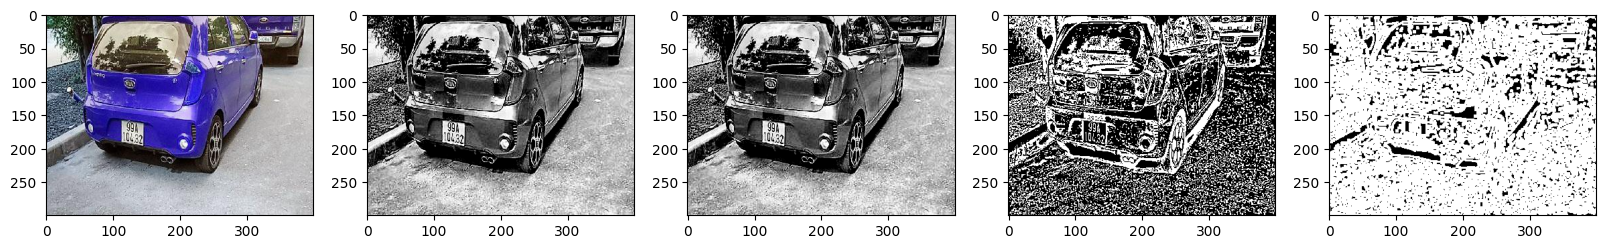

In [68]:
ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
plt.figure(figsize=(20, 8))
plt.subplot(2, 5, 1)
plt.imshow(image)
y, _, _ = cv2.split(ycrcb_image)
y = maximizeContrast(y)
plt.subplot(2, 5, 2)
plt.imshow(y, cmap='gray')
#blurred_y = cv2.GaussianBlur(y, (5, 5), 0)
plt.subplot(2, 5, 3)
plt.imshow(y, cmap='gray')
thresholded = cv2.adaptiveThreshold(y, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)
plt.subplot(2, 5, 4)
plt.imshow(thresholded, cmap='gray')
canny_image = cv2.Canny(thresholded, 250, 255)
kernel = np.ones((3, 3), np.uint8)
dilated_image = cv2.dilate(canny_image, kernel, iterations=1)
plt.subplot(2, 5, 5)
plt.imshow(dilated_image, cmap='gray')
plt.show()

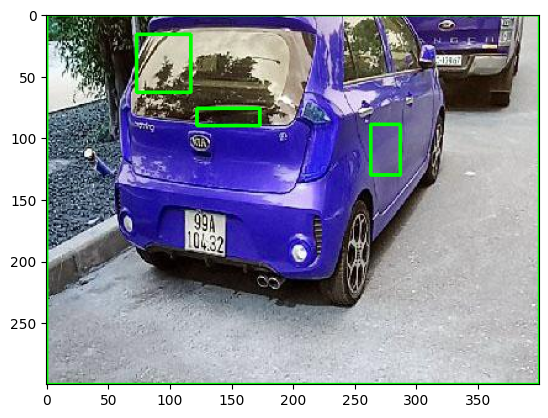

In [69]:
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

screenCnt = []
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.06 * peri, True)
    [x, y, w, h] = cv2.boundingRect(approx.copy())
    ratio = w / h
    if len(approx) == 4:
        screenCnt.append(approx)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(image)
plt.show()